In [1]:
import numpy as np
from scipy.stats import truncnorm, norm, binom
import matplotlib.pyplot as plt
import random

In [2]:
cutoff = 0.95

In [3]:
class Wafer:
    pass

In [4]:
class SolarCell:
    def __init__(self, working):
        self.working = working

In [5]:
class Machine:
    runtime = 0  #In Minutes
    costs = 0
    
    def __init__(self, p):  #Constructor
        self.p = p
    
    def deposit(self, wafer):
        self.runtime += 9    #9 minutes per deposition per wafer
        self.costs += 2 + 87/35  #It costs €2 to do a deposition. Wafers have a base cost of €87, but can be re-used 35 times
        working = random.random() < self.p 
        
        return SolarCell(working)
    
    def diagnosis(self, cell):
        self.runtime += 2 if cell.working else 3  # Diagnosis costs 2 minutes if the created cell works, 3 minutes otherwise
        return cell.working
    
    def test_basic(self, n):
        wafers = n * [Wafer()] # Create list of n Wafer() objects
        cells = list(map(self.deposit, wafers)) # Deposit all wafers
        working_cells = list(filter(self.diagnosis, cells)) # Make list of working cells
        return len(working_cells)/len(cells) # Determine ratio of the amount of working cells and total cells 
    
    def get_stats(self):
        days = self.runtime // (24 * 60)
        hours = (self.runtime % (24 * 60)) // 60
        minutes = (self.runtime % (24 * 60)) % 60
        rcosts = round(self.costs, 2)
        
        print("Actual accuracy of machine:", self.p)
        print("It takes", days, "day(s),", hours, "hour(s) and", minutes, "minute(s) to test.")
        print("The costs associated with this test method is €" + str(rcosts))
        
    def reset(self):
        self.runtime = 0
        self.costs = 0
        
    def plot_basic(self, n):
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p),
                      binom.ppf(1, n, self.p))
        ax.plot(x/n, binom.pmf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.pmf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.set_xlabel("estimated p")
        ax.set_ylabel("probability")
        plt.show()
        
    def false_negative_basic(self, n):
        return binom.cdf(int(0.95 * n), n, self.p)
    
    # Testing with variable number of tests
    def test_advanced(self, certainty, max_tests):
        successes = 0
        p_ = 1
        
        for n in range(1, max_tests):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
            
            (left, right) = self.calculate_interval(certainty, n, p_)
            print("Left: " + str(left))
            print("Right: " + str(right))
            
            if (left / n > cutoff and right / n > cutoff):
                return (p_, n)
            
            if (left / n < cutoff and right / n < cutoff):
                return (p_, n)
            
        return (p_, n)
            
    def calculate_interval(self, certainty, n, p_):
        error = (1 - certainty)/2

        left = binom.ppf(max(p_ - error, 0), n, self.p)
        right = binom.ppf(min(1, p_ + error), n, self.p)
        
        left = max(left / n, 0)
        right = min(right/n, 1)
        return (left, right)

In [6]:
def makeMachine(mu, sigma):
    p = truncnorm(-mu / sigma, (1 - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]
    return Machine(p)

In [7]:
b = makeMachine(0.98, 0.02)

In [8]:
p_ = b.test_basic(10)
print("Projected accuracy of machine:", p_)
b.get_stats()
b.reset()

Projected accuracy of machine: 1.0
Actual accuracy of machine: 0.9449742906620231
It takes 0 day(s), 1 hour(s) and 50 minute(s) to test.
The costs associated with this test method is €44.86


Truncated normal distribution vs normal distribution [from here](https://stackoverflow.com/questions/18441779/how-to-specify-upper-and-lower-limits-when-using-numpy-random-normal)

In [9]:
lower, upper = 0, 1
mu, sigma = 0.99, 0.03
X = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

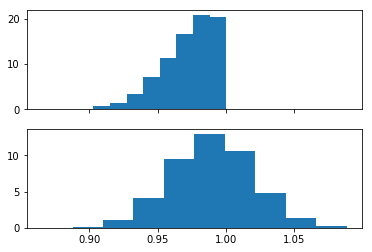

In [10]:
N = norm(loc=mu, scale=sigma)

fig, ax = plt.subplots(2, sharex=True)
ax[0].hist(X.rvs(10000), normed=True)
ax[1].hist(N.rvs(10000), normed=True)
plt.show()

In [11]:
m = Machine(0.94)

In [12]:
p_ = m.test_basic(100)
print("Estimated probability: " + str(p_))
m.get_stats()
m.reset()

Estimated probability: 0.92
Actual accuracy of machine: 0.94
It takes 0 day(s), 18 hour(s) and 28 minute(s) to test.
The costs associated with this test method is €448.57


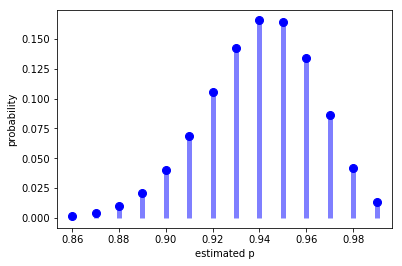

In [13]:
m.plot_basic(100)

In [14]:
def neighbourhood(machine, epsilon, p, n):
    return binom.cdf(p + epsilon, n, machine.p) - binom.cdf(p - epsilon, n, machine.p)

In [15]:
neighbourhood(m, 1, 97, 100)

0.12785199135923309

Interval rond p_, met 97.5%?? kans dat die er in ligt. Hoe groter aantal tests n, hoe kleiner interval. Als het gehele interval boven 95% ligt, stop met testen, en het is een goede machine (met 97.5% zekerheid). Als het gehele interval onder 95% ligt, dan is het een slechte machine (met 97.5% zekerheid).

In [16]:
m = Machine(0.9)

In [17]:
m.test_advanced(0.9, 1000)

Left: 1.0
Right: 1.0


(1.0, 1)

In [18]:
m.calculate_interval(0.95, 500, 0.96)

(0.92, 0.928)

In [19]:
p_ = 0.97

In [20]:
binom.ppf(p_ + 0.01, 100, 0.97)

100.0

In [21]:
binom.ppf(1, 10, 0.5)

10.0

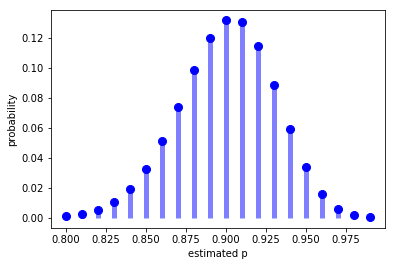

In [22]:
m.plot_basic(100)